In [1]:
# by M. Fouesneau
def add_input_toggle():
    from IPython.display import HTML, display

    r = HTML('''
    <script>
    $( document ).ready(function () {
        IPython.CodeCell.options_default['cm_config']['lineWrapping'] = true;
        IPython.notebook.get_selected_cell()
        IPython.toolbar.add_buttons_group([
                {
                    'label'   : 'toggle all input cells',
                    'icon'    : 'fa-eye-slash',
                    'callback': function(){ $('div.input').slideToggle(); }
                }
            ]);
    });
    </script>
    ''')
    display(r)
    return r

if(not 'input_toggle' in locals()):
    input_toggle = add_input_toggle()

In [2]:
%matplotlib inline
import pencil_old as pencil
import numpy
from matplotlib import pyplot
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import __version__
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import os

print(sys.version)
print(__version__)

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc
2.7.13 |Anaconda custom (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
2.0.0


In [22]:
# reading in gas state snapshot

time_series = pencil.read_ts(quiet=True)
last_snap = int(numpy.floor(time_series.t[-1]/0.014))

#ivars = numpy.arange(start=0,stop=last_snap,step=10,dtype=int)
ivars = numpy.linspace(start=1,stop=last_snap,num=4,dtype=int)
nsnaps = len(ivars)

data_array = numpy.empty(nsnaps,dtype=object)
for i in range(nsnaps):
    ivar = ivars[i]
    data_array[i] = pencil.read_var(ivar=ivar,trimall=True,quiet=True)

print("times: ")
for data in data_array:
    print(data.t)

times: 
0.0140002943956
1.26000027224
2.52000018097
3.78000008922


In [23]:
data = data_array[0]
xgrid   = data.x ; nx = len(xgrid) ; dxgrid  = data.dx ; x0 = xgrid[0] ; x1 = xgrid[-1]
ygrid   = data.y ; ny = len(ygrid) ; dygrid  = data.dy ; y0 = ygrid[0] ; y1 = ygrid[-1]
zgrid   = data.z ; nz = len(zgrid) ; dzgrid  = data.dz ; z0 = zgrid[0] ; z1 = zgrid[-1]
ux = numpy.transpose(data.ux)
uy = numpy.transpose(data.uy)
uz = numpy.transpose(data.uz)

We want to figure out whether or not the simulation set up we're using causes the gas in the chamber to adopt a solid body rotation profile.

For the time being, I do this by computing what the x and y components of that velocity profile should be at all the grid points, and then compare that with the gas velocity from the simulation.

In [24]:
# omega: the angular velocity of the chamber wall. for a solid body rotation profile,
# all of the gas in the chamber should rotate about the central axis with this omega
omega  = 1.05
ux_rot = numpy.zeros((nx,ny))
uy_rot = numpy.zeros((nx,ny))
for ix in range(nx):
    for iy in range(ny):
        x_l  = xgrid[ix]                ; y_l    = ygrid[iy]
        ux_l = ux[ix,iy]                ; uy_l   = uy[ix,iy]
# v = r*omega, and v must be projected along x and y; r,phi are needed
        r_l  = (x_l**2 + y_l**2)**(0.5) ; phi_l  = numpy.arctan2(y_l,x_l)
        u_l  = r_l*omega
        ux_rot[ix,iy] = u_l*numpy.sin(phi_l) ; uy_rot[ix,iy] = -u_l*numpy.cos(phi_l)

# **plotting the solid body rotation velocity, to make sure it makes sense:**

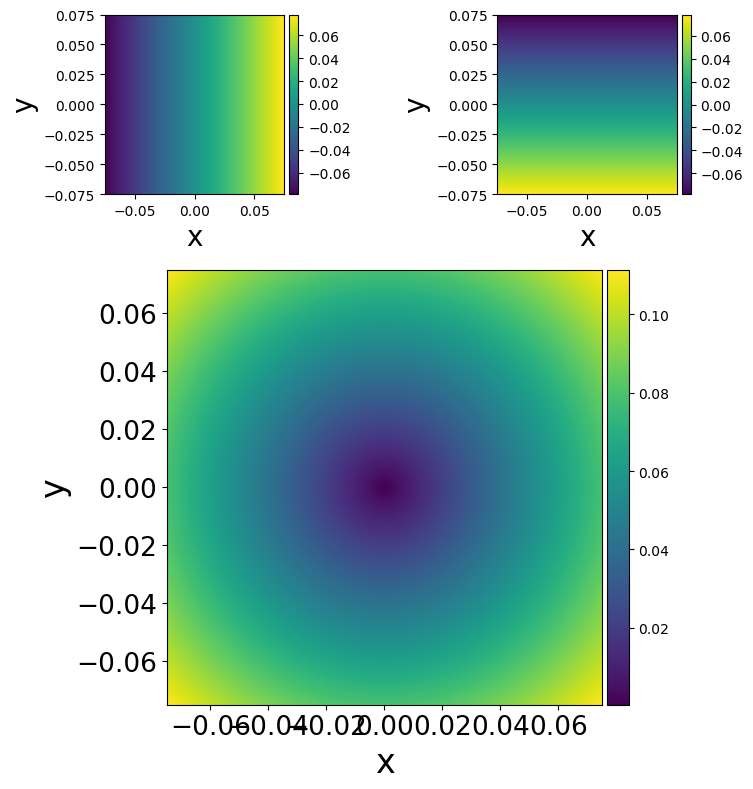

In [25]:
# make figure, with properties that hopefully make it look good
fig = pyplot.figure(tight_layout=True)
fig.set_size_inches(8.0,8.0)
fig.set_dpi(100)

# set up subplot grid
grid = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1:,0:])

# contour x component of solid body rotation velocity
contour1 = ax1.pcolormesh(xgrid,ygrid,ux_rot)
ax1.set_xlim([x0,x1])
ax1.set_ylim([y0,y1])
ax1.set_aspect("equal")
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour1,cax=cax1)
ax1.set_xlabel(r"x",fontsize=20)
ax1.set_ylabel(r"y",fontsize=20)
ax1.tick_params(axis='x')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
#for tick in cax1.get_major_ticks():
#    tick.label.set_fontsize(10)

# contour y component of solid body rotation velocity
contour2 = ax2.pcolormesh(xgrid,ygrid,uy_rot)
ax2.set_xlim([x0,x1])
ax2.set_ylim([y0,y1])
ax2.set_aspect("equal")
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour2,cax=cax2)
ax2.set_xlabel(r"x",fontsize=20)
ax2.set_ylabel(r"y",fontsize=20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

# contour magnitude of rotational velocity
u_rot_mag = (ux_rot**2 + uy_rot**2)**(0.5)
contour3 = ax3.pcolormesh(xgrid,ygrid,u_rot_mag)
ax3.set_xlim([x0,x1])
ax3.set_ylim([y0,y1])
ax3.set_aspect("equal")
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour3,cax=cax3)
ax3.set_xlabel(r"x",fontsize=24)
ax3.set_ylabel(r"y",fontsize=24)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)

# **Now, plotting the gas velocity from the simulation:**

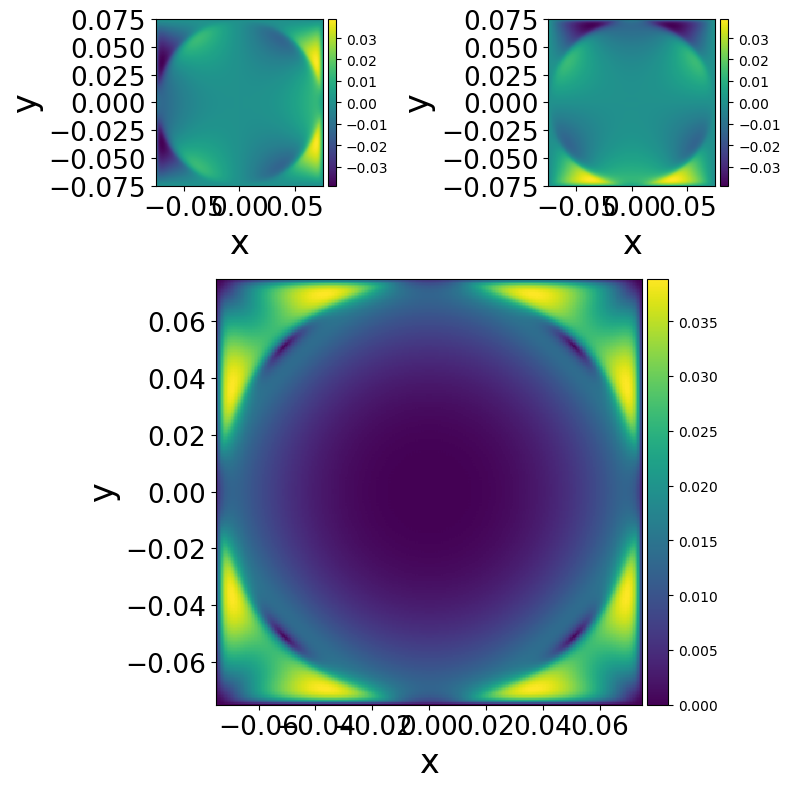

In [26]:
fig = pyplot.figure(tight_layout=True)
fig.set_size_inches(8.0,8.0)
fig.set_dpi(100)

# set up subplot grid
grid = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1:,0:])

# define a reference slice in z, and slice the velocities on it
z_ref  = 0.0
iz_ref = numpy.where(numpy.abs(z_ref - zgrid) == numpy.abs(z_ref - zgrid).min())[0][0]
ux_ref = ux[:,:,iz_ref] ; uy_ref = uy[:,:,iz_ref] ; uz_ref = uz[:,:,iz_ref]

# somethsdlktna forgot hmmm
contour1 = ax1.pcolormesh(xgrid,ygrid,ux_ref)
ax1.set_xlim([x0,x1])
ax1.set_ylim([y0,y1])
ax1.set_aspect("equal")
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour1,cax=cax1)
ax1.set_xlabel(r"x",fontsize=24)
ax1.set_ylabel(r"y",fontsize=24)

# contour y component of gas velocity
contour2 = ax2.pcolormesh(xgrid,ygrid,uy_ref)
ax2.set_xlim([x0,x1])
ax2.set_ylim([y0,y1])
ax2.set_aspect("equal")
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour2,cax=cax2)
ax2.set_xlabel(r"x",fontsize=24)
ax2.set_ylabel(r"y",fontsize=24)

# contour magnitude of velocity
u_ref_mag = (ux_ref**2 + uy_ref**2)**(0.5)
contour3 = ax3.pcolormesh(xgrid,ygrid,u_ref_mag)
ax3.set_xlim([x0,x1])
ax3.set_ylim([y0,y1])
ax3.set_aspect("equal")
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour3,cax=cax3)
ax3.set_xlabel(r"x",fontsize=24)
ax3.set_ylabel(r"y",fontsize=24)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)

# try to make a panel to show time evolution

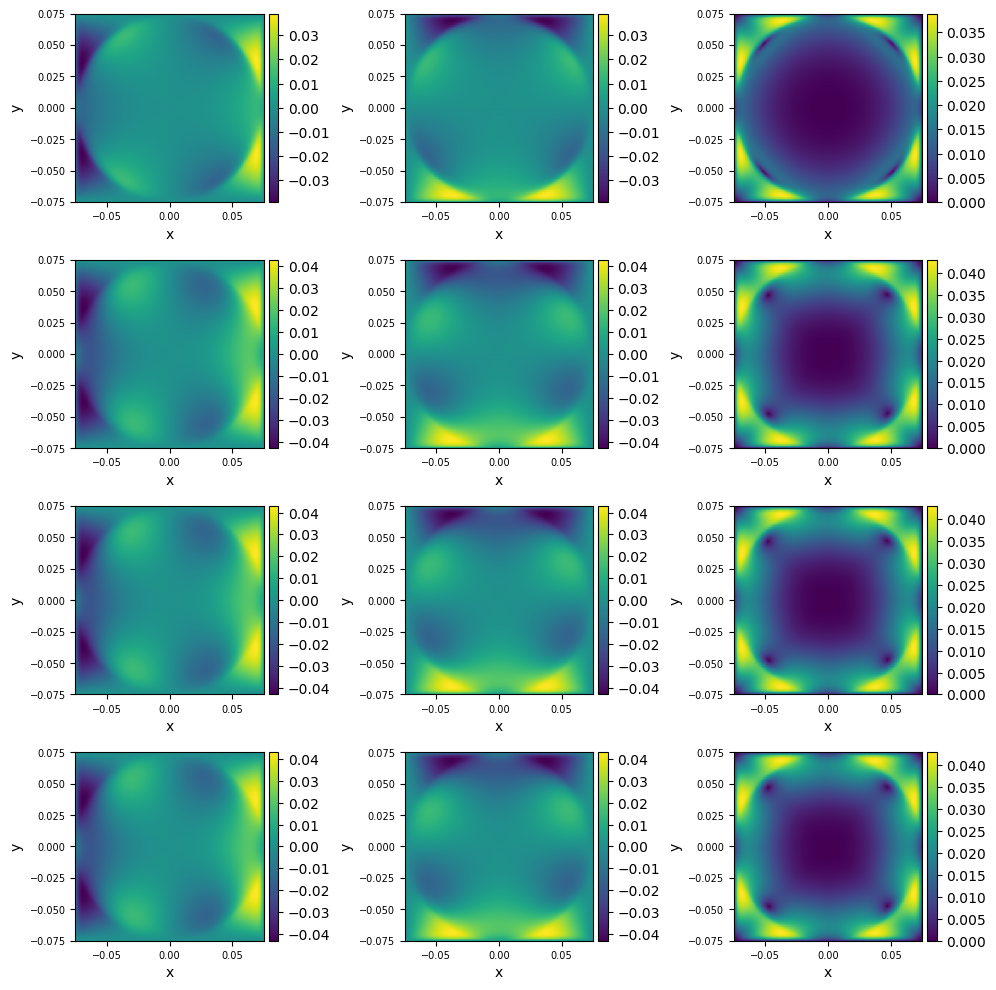

In [27]:
fig = pyplot.figure(tight_layout=True)
fig.set_size_inches(10.0,10.0)
fig.set_dpi(100)

fontsize = 10
tick_fontsize = 7

# set up subplot grid
ax = numpy.empty((nsnaps,3),dtype=object)
grid = gridspec.GridSpec(nsnaps,3)
for i in range(nsnaps):
    ax[i,0] = fig.add_subplot(grid[i,0])
    ax[i,1] = fig.add_subplot(grid[i,1])
    ax[i,2] = fig.add_subplot(grid[i,2])
#ax40 = fig.add_subplot(grid[0,0]) ; ax41 = fig.add_subplot(grid[0,1]) ; ax42 = fig.add_subplot(grid[0,2])
#ax50 = fig.add_subplot(grid[0,0]) ; ax51 = fig.add_subplot(grid[0,1]) ; ax52 = fig.add_subplot(grid[0,2])
#ax60 = fig.add_subplot(grid[0,0]) ; ax61 = fig.add_subplot(grid[0,1]) ; ax62 = fig.add_subplot(grid[0,2])
#ax70 = fig.add_subplot(grid[0,0]) ; ax71 = fig.add_subplot(grid[0,1]) ; ax72 = fig.add_subplot(grid[0,2])
#ax80 = fig.add_subplot(grid[0,0]) ; ax81 = fig.add_subplot(grid[0,1]) ; ax82 = fig.add_subplot(grid[0,2])
#ax90 = fig.add_subplot(grid[0,0]) ; ax91 = fig.add_subplot(grid[0,1]) ; ax92 = fig.add_subplot(grid[0,2])

# define a reference slice in z, and slice the velocities on it
z_ref  = 0.0
iz_ref = numpy.where(numpy.abs(z_ref - zgrid) == numpy.abs(z_ref - zgrid).min())[0][0]

for i in range(nsnaps):
    data = data_array[i]
    ux = numpy.transpose(data.ux)
    uy = numpy.transpose(data.uy)
    uz = numpy.transpose(data.uz)
    rho = numpy.transpose(data.rho)
    ux_ref = ux[:,:,iz_ref] ; uy_ref = uy[:,:,iz_ref] ; uz_ref = uz[:,:,iz_ref]
    
    contour1 = ax[i,0].pcolormesh(xgrid,ygrid,ux_ref)
    ax[i,0].set_xlim([x0,x1])
    ax[i,0].set_ylim([y0,y1])
    ax[i,0].set_aspect("equal")
    div1 = make_axes_locatable(ax[i,0])
    cax1 = div1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(contour1,cax=cax1)
    ax[i,0].set_xlabel(r"x",fontsize=fontsize)
    ax[i,0].set_ylabel(r"y",fontsize=fontsize)
    
    contour2 = ax[i,1].pcolormesh(xgrid,ygrid,uy_ref)
    ax[i,1].set_xlim([x0,x1])
    ax[i,1].set_ylim([y0,y1])
    ax[i,1].set_aspect("equal")
    div2 = make_axes_locatable(ax[i,1])
    cax2 = div2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(contour2,cax=cax2)
    ax[i,1].set_xlabel(r"x",fontsize=fontsize)
    ax[i,1].set_ylabel(r"y",fontsize=fontsize)
    
    u_ref_mag = (ux_ref**2 + uy_ref**2)**(0.5)
    contour3 = ax[i,2].pcolormesh(xgrid,ygrid,u_ref_mag)
    ax[i,2].set_xlim([x0,x1])
    ax[i,2].set_ylim([y0,y1])
    ax[i,2].set_aspect("equal")
    div3 = make_axes_locatable(ax[i,2])
    cax3 = div3.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(contour3,cax=cax3)
    ax[i,2].set_xlabel(r"x",fontsize=fontsize)
    ax[i,2].set_ylabel(r"y",fontsize=fontsize)
    
    for tick in ax[i,0].xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_fontsize)
    for tick in ax[i,0].yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_fontsize)
    for tick in ax[i,1].xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_fontsize)
    for tick in ax[i,1].yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_fontsize)
    for tick in ax[i,2].xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_fontsize)
    for tick in ax[i,2].yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_fontsize)

# Finally, the difference between the two:

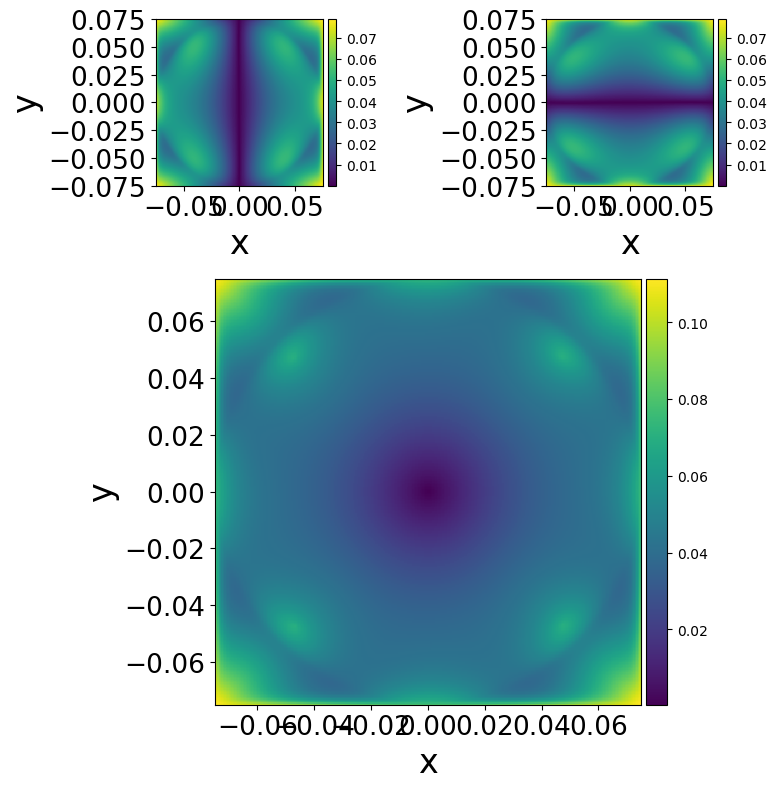

In [28]:
fig = pyplot.figure(tight_layout=True)
fig.set_size_inches(8.0,8.0)
fig.set_dpi(100)

# set up subplot grid
grid = gridspec.GridSpec(3,2)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1:,0:])

# define a reference slice in z, and slice the velocities on it
z_ref  = 0.0
iz_ref = numpy.where(numpy.abs(z_ref - zgrid) == numpy.abs(z_ref - zgrid).min())[0][0]
ux_ref = ux[:,:,iz_ref] ; uy_ref = uy[:,:,iz_ref] ; uz_ref = uz[:,:,iz_ref]

# contour x component of gas velocity
contour1 = ax1.pcolormesh(xgrid,ygrid,numpy.abs(ux_ref - ux_rot))
ax1.set_xlim([x0,x1])
ax1.set_ylim([y0,y1])
ax1.set_aspect("equal")
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour1,cax=cax1)
ax1.set_xlabel(r"x",fontsize=24)
ax1.set_ylabel(r"y",fontsize=24)

# contour y component of gas velocity
contour2 = ax2.pcolormesh(xgrid,ygrid,numpy.abs(uy_ref - uy_rot))
ax2.set_xlim([x0,x1])
ax2.set_ylim([y0,y1])
ax2.set_aspect("equal")
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour2,cax=cax2)
ax2.set_xlabel(r"x",fontsize=24)
ax2.set_ylabel(r"y",fontsize=24)

# contour magnitude of velocity
contour3 = ax3.pcolormesh(xgrid,ygrid,numpy.abs(u_ref_mag - u_rot_mag))
ax3.set_xlim([x0,x1])
ax3.set_ylim([y0,y1])
ax3.set_aspect("equal")
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour3,cax=cax3)
ax3.set_xlabel(r"x",fontsize=24)
ax3.set_ylabel(r"y",fontsize=24)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)

**density**

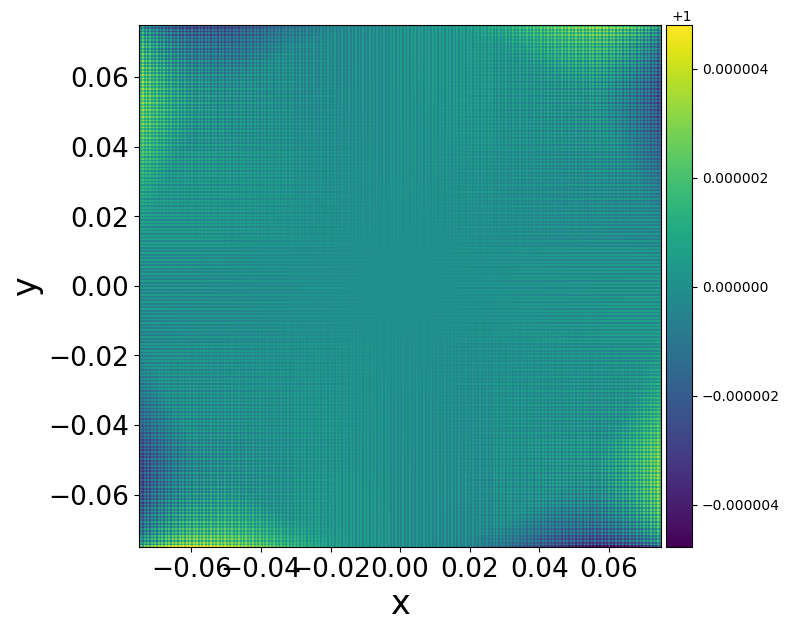

In [29]:
fig = pyplot.figure(tight_layout=True)
fig.set_size_inches(8.0,8.0)
fig.set_dpi(100)

# set up subplot grid
ax1 = fig.add_subplot(111)

# define a reference slice in z, and slice the velocities on it
z_ref  = 0.0
iz_ref = numpy.where(numpy.abs(z_ref - zgrid) == numpy.abs(z_ref - zgrid).min())[0][0]
rho_ref = rho[:,:,iz_ref]

# contour x component of gas velocity
contour1 = ax1.pcolormesh(xgrid,ygrid,rho_ref)
ax1.set_xlim([x0,x1])
ax1.set_ylim([y0,y1])
ax1.set_aspect("equal")
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(contour1,cax=cax1)
ax1.set_xlabel(r"x",fontsize=24)
ax1.set_ylabel(r"y",fontsize=24)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(19)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(19)